<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.metrics.scorer import make_scorer
from sklearn.dummy import DummyRegressor
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df = df.resample('1H').sum()

In [5]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Данные загружены, библиотеки и функции импортированы, ресемплирование по часу выполнено. Переходим к анализу данных.

## Анализ

Давайте посмотрим как ведут себя данные, их скользящее среднее, тренды и сезонность.

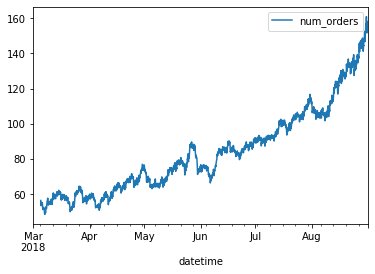

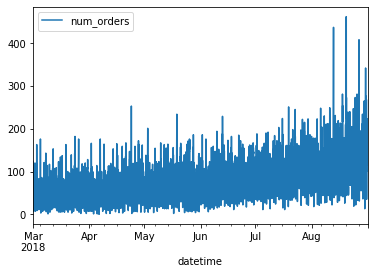

In [6]:
df.rolling(100).mean().plot()
df.plot()

Мы видим по росту среднего, что с марта по август 2018 года среднее количество заказов такси увеличилось в 2.5 раза. По самому графику данных это гораздо менее заметно.

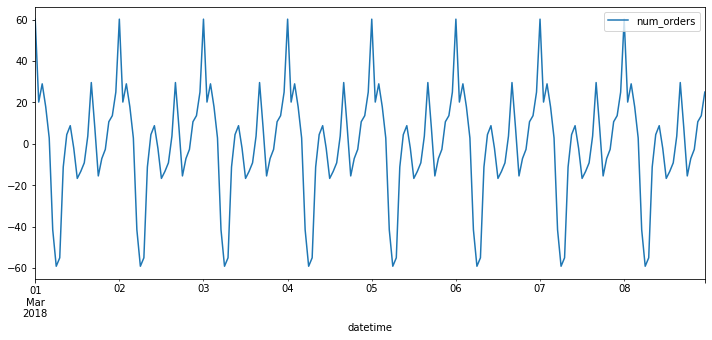

In [7]:
decomposed = seasonal_decompose(df)
decomposed.seasonal['2018-03-01':'2018-03-08'].plot(ax = plt.gca(), figsize = (12, 5))

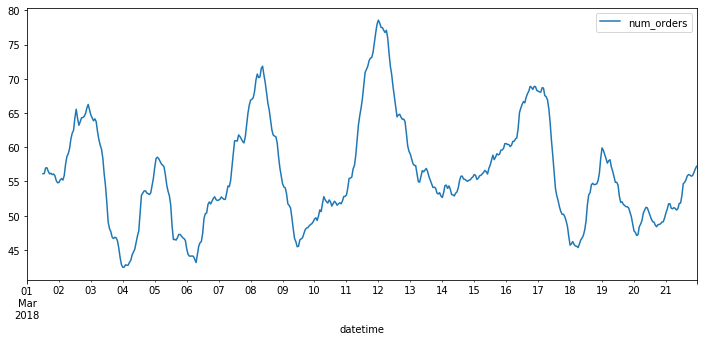

In [8]:
decomposed.trend['2018-03-01':'2018-03-21'].plot(ax = plt.gca(), figsize = (12, 5))

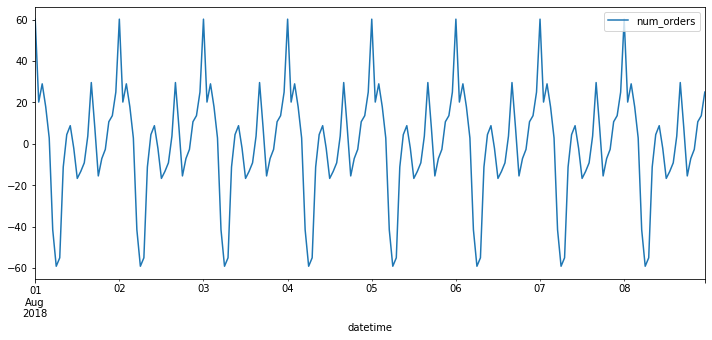

In [9]:
decomposed.seasonal['2018-08-01':'2018-08-08'].plot(ax = plt.gca(), figsize = (12, 5))

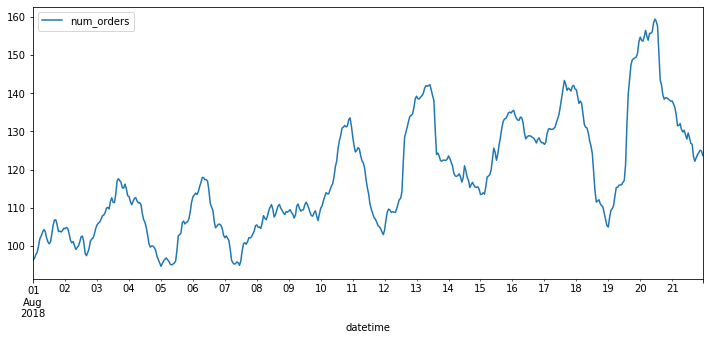

In [10]:
decomposed.trend['2018-08-01':'2018-08-21'].plot(ax = plt.gca(), figsize = (12, 5))

По этим графикам мы можем сказать что сезонность по часам работы очень простая и логичная - люди пользуются услугами такси с утра до ночи, с повышением спроса 1) с утра когда едут на работу, 2) в обед, 3) когда поздно возвращаются с работы или какого то мероприятия.

Что касается трендов, то глядя на календарь 2018 года мы можем заметить что и в марте и в августе самые большие скачки заказов вверх происходят в пятницу и субботу когда люди развлекаются после рабочей недели и в понедельник видимо им сложно вовремя проснуться на работу. Всю остальную неделю график находится значительно ниже, и чаще всего занимает свое минимальное положение в воскресенье.

В принципе изменение спроса вполне понятно, давайте перейдем к обучению моделей.

## Обучение

Для начала выведем с помощью функций временного ряда признаки с помощью которых будет обучаться модель, затем обучим 4 модели (решающее древо, случайный лес, линейная регрессия и LightGBM), подберем им оптимальные параметры и перейдем к тестированию.

Что касается создания признаков, я считаю что поскольку у нас на графике скользящего среднего график сильно возрастает, нам будет нужно больше разностей временного ряда чтобы модель видела увеличение заказов с течением времени, и соответственно при проверке обучения моделей, нам нужно будет не только менять гиперпараметры моделей но и параметры создания признаков.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return(data)

In [12]:
df = make_features(df, 24, 24)
df.head()

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [14]:
%%time
best_result_1 = 10000
best_depth_1 = 0
for depth_1 in range(1, 50):
    model_1 = DecisionTreeRegressor(random_state = 12345, max_depth = depth_1)
    model_1.fit(features_train, target_train)
    answer_1 = model_1.predict(features_test)
    result_1 = mean_squared_error(answer_1, target_test) ** 0.5
    if result_1 < best_result_1:
        best_model_1 = model_1
        best_result_1 = result_1
        best_depth_1 = depth_1

print("Лучший результат:", best_result_1, "Глубина дерева:", best_depth_1)

Лучший результат: 55.120566197906754 Глубина дерева: 8
CPU times: user 4.44 s, sys: 168 µs, total: 4.44 s
Wall time: 4.55 s


In [15]:
%%time
my_scorer = make_scorer(mean_squared_error)
model_2 = RandomForestRegressor(random_state = 12345, n_estimators = 13, max_depth = 7)
np.mean(cross_val_score(model_2, features_train, target_train, scoring=my_scorer, cv = 4)) ** 0.5

CPU times: user 1.3 s, sys: 11.4 ms, total: 1.31 s
Wall time: 1.33 s


26.79649717831357

In [16]:
%%time
model_3 = LinearRegression()
model_3.fit(features_train, target_train)
answer_3 = model_3.predict(features_test)
result_3 = mean_squared_error(answer_3, target_test) ** 0.5
result_3

CPU times: user 27 ms, sys: 60.2 ms, total: 87.1 ms
Wall time: 91.6 ms


44.99004167816794

In [17]:
%%time
model_4 = LGBMRegressor()
model_4.fit(features_train, target_train)
answer_4 = model_4.predict(features_test)
result_4 = mean_squared_error(answer_4, target_test) ** 0.5
result_4

CPU times: user 1.78 s, sys: 74.1 ms, total: 1.85 s
Wall time: 1.91 s


42.2727031118916

На данный момент нашим требованиям удовлетворяют три модели, давайте проверим как отработает модель с тестовыми данными.

## Тестирование

In [18]:
model_rfr = RandomForestRegressor(random_state = 12345, n_estimators = 21, max_depth = 8)
model_rfr.fit(features_train, target_train)
answer_rfr = model_rfr.predict(features_test)
result_rfr = mean_squared_error(answer_rfr, target_test) ** 0.5
result_rfr

45.63193862226019

Text(0, 0.5, 'Количество заказов')

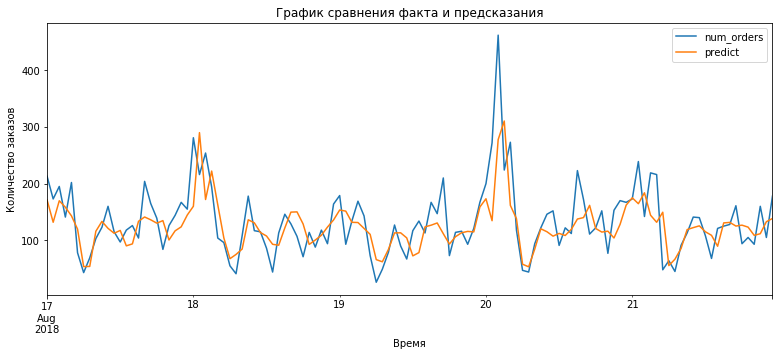

In [19]:
df_rfr = pd.DataFrame(target_test)
df_rfr['predict'] = answer_rfr
df_rfr['2018-08-17':'2018-08-21'].plot(figsize = (13, 5))
plt.title('График сравнения факта и предсказания')
plt.xlabel("Время")
plt.ylabel("Количество заказов")

In [20]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
answer_lr = model_lr.predict(features_test)
result_lr = mean_squared_error(answer_lr, target_test) ** 0.5
result_lr

44.99004167816794

Text(0, 0.5, 'Количество заказов')

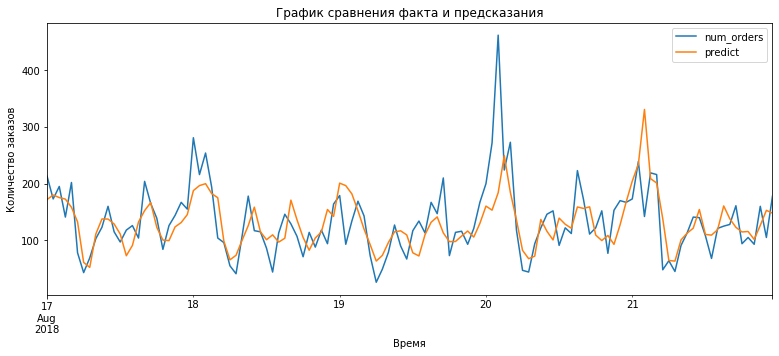

In [21]:
df_lr = pd.DataFrame(target_test)
df_lr['predict'] = answer_lr
df_lr['2018-08-17':'2018-08-21'].plot(figsize = (13, 5))
plt.title('График сравнения факта и предсказания')
plt.xlabel("Время")
plt.ylabel("Количество заказов")

In [22]:
model_gbm = LGBMRegressor()
model_gbm.fit(features_train, target_train)
answer_gbm = model_gbm.predict(features_test)
result_gbm = mean_squared_error(answer_gbm, target_test) ** 0.5
result_gbm

42.2727031118916

Text(0, 0.5, 'Количество заказов')

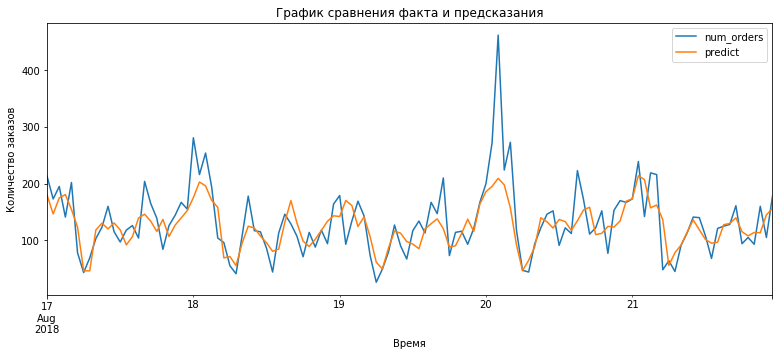

In [23]:
df_gbm = pd.DataFrame(target_test)
df_gbm['predict'] = answer_gbm
df_gbm['2018-08-17':'2018-08-21'].plot(figsize = (13, 5))
plt.title('График сравнения факта и предсказания')
plt.xlabel("Время")
plt.ylabel("Количество заказов")

### Вывод:

Были обучены три модели, которые смогли предсказать количество заказов на тестовой выборке c необходимой точностью, самую высокую из них показала модель градиентного бустинга. Теперь можно будет представить все три модели заказчику с графиками сравнения факта и предсказаний, и пусть заказчик сам решает предсказания какой модели ему нравится больше. По графикам видно что модель градиентного бустинга предсказывает более усредненные результаты, чаще всего с занижением к реальному кол-ву заказов и как мне кажется бизнесу лучше ориентироваться на заниженые предсказания чтобы не ошибиться в части расходов и прибыли, а модель случайного леса лучше чувствует тренды, но за счет этого менее точна т.к. более склонна к выбросам.